# Input Driven Observations ("GLM-HMM")

Notebook adapted from Zoe Ashwood

This notebook demonstrates the "InputDrivenObservations" class, and illustrates its use in the context of modeling decision-making data as in Ashwood et al. (2020) ([Mice alternate between discrete strategies during perceptual
decision-making](https://www.biorxiv.org/content/10.1101/2020.10.19.346353v1.full.pdf)).

Compared to the model considered in the notebook ["2 Input Driven HMM"](https://github.com/lindermanlab/ssm/blob/master/notebooks/2%20Input%20Driven%20HMM.ipynb), Ashwood et al. (2020) assumes a stationary transition matrix where transition probabilities *do not* depend on external inputs. However, observation probabilities now *do* depend on external covariates according to:


for $c \neq C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

and for $c = C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{1}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

where $c \in \{1, ..., C\}$ indicates the categorical class for the observation, $u_{t} \in \mathbb{R}^{M}$ is the set of input covariates, and $w_{kc} \in \mathbb{R}^{M}$ is the set of input weights associated with state $k$ and class $c$. These weights, along with the transition matrix and initial state probabilities, will be learned.

In Ashwood et al. (2020), $C = 2$ as $y_{t}$ represents the binary choice made by an animal during a 2AFC (2-Alternative Forced Choice) task. The above equations then reduce to:

$$
\begin{align}
\Pr(y_t = 0 \mid z_{t} = k, u_t, w_{k}) = 
\frac{\exp\{w_{k}^\mathsf{T} u_t\}}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}} = \frac{1}
{1 + \exp\{-w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

$$
\begin{align}
\Pr(y_t = 1 \mid z_{t} = k, u_t, w_{k}) = 
\frac{1}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

and only a single weight vector, $w_{k}$, is associated with each state.

## 1. Setup
First, you must clone the `ssm` repository and install all of the dependencies. The `ssm` package we are using can be found, along with installation instructions, [here](https://github.com/lindermanlab/ssm.git). 

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [1]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sglm import hmmUtils, utils
import ssm

npr.seed(42)

#### 1a. Import your data

In [2]:
data_ = pd.read_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FreelyMoving_6nback_102323_wDOB_wrecordDF.csv')
#filtered_data = pd.read_csv(r'C:\Users\janet\Documents\Behavior_samp_data\HMM_6nback_102323_wDOB_wrecordDF.csv')


C:\Users\janet\AppData\Local\Temp\ipykernel_14104\2110500065.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ = pd.read_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FreelyMoving_6nback_102323_wDOB_wrecordDF.csv')


In [6]:
probs = '80-20'
filtered_data = data_[(data_['Condition'] == probs)]

In [9]:
filtered_data.loc[:, '3_Reward'] = filtered_data['3_Reward'].replace(0, -1)

In [10]:
#add columns for interaction between reward and choice
filtered_data.loc[:, '1_ChoiceReward'] = filtered_data['1_Port'] * filtered_data['1_Reward']
filtered_data.loc[:, '2_ChoiceReward'] = filtered_data['2_Port'] * filtered_data['2_Reward']
filtered_data.loc[:, '3_ChoiceReward'] = filtered_data['3_Port'] * filtered_data['3_Reward']

C:\Users\janet\AppData\Local\Temp\ipykernel_14104\1374730130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, '1_ChoiceReward'] = filtered_data['1_Port'] * filtered_data['1_Reward']
C:\Users\janet\AppData\Local\Temp\ipykernel_14104\1374730130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, '2_ChoiceReward'] = filtered_data['2_Port'] * filtered_data['2_Reward']
C:\Users\janet\AppData\Local\Temp\ipykernel_14104\1374730130.py:4: SettingWithCopyWarning: 
A value 

In [11]:
filtered_data

,Unnamed: 0,Trial,Block Trial,0_ITI,0_trialDuration,Decision,1_Port,1_Reward,1_ITI,1_trialDuration,...,Start_Age,Age_Group,Cohort_Name,Trial_based,Fibers,Dreadds_During_Training,Age at Recording,1_ChoiceReward,2_ChoiceReward,3_ChoiceReward
2702,2702,7,7,1.474,0.334,1,1,1,7.347,0.571,...,206.0,3.0,Aging_Cohort_KM,1.0,0.0,0.0,226.0,1,-1,0
2703,2703,8,8,1.849,0.353,1,1,1,1.474,0.334,...,206.0,3.0,Aging_Cohort_KM,1.0,0.0,0.0,226.0,1,1,-1
2704,2704,9,9,1.818,0.367,1,1,1,1.849,0.353,...,206.0,3.0,Aging_Cohort_KM,1.0,0.0,0.0,226.0,1,1,1
2705,2705,10,10,1.318,0.527,1,1,-1,1.818,0.367,...,206.0,3.0,Aging_Cohort_KM,1.0,0.0,0.0,226.0,-1,1,1
2706,2706,11,11,1.473,0.461,0,1,-1,1.318,0.527,...,206.0,3.0,Aging_Cohort_KM,1.0,0.0,0.0,226.0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604844,604844,484,3,1.456,0.597,0,0,-1,1.609,0.564,...,48.0,1.0,Aging_Cohort_WCL,1.0,0.0,0.0,73.0,0,0,0
604845,604845,485,4,12.766,0.347,0,0,-1,1.456,0.597,...,48.0,1.0,Aging_Cohort_WCL,1.0,0.0,0.0,73.0,0,0,0
604846,604846,486,5,3.087,0.249,0,0,1,12.766,0.347,...,48.0,1.0,Aging_Cohort_WCL,1.0,0.0,0.0,73.0,0,0,0
604847,604847,487,6,2.400,0.315,0,0,1,3.087,0.249,...,48.0,1.0,Aging_Cohort_WCL,1.0,0.0,0.0,73.0,0,0,0


## 2. Input Driven Observations
We create a HMM with input-driven observations and 'standard' (stationary) transitions with the following line:  
```python
        ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", observation_kwargs=dict(C=num_categories), transitions="standard")
```

As in Ashwood et al. (2020), we are going to model an animal's binary choice data during a decision-making task, so we will set `num_categories=2` because the animal only has two options available to it. We will also set `obs_dim = 1` because the dimensionality of the observation data is 1 (if we were also modeling, for example, the binned reaction time of the animal, we could set `obs_dim = 2`).  For the sake of simplicity, we will assume that an animal's choice in a particular state is only affected by the external stimulus associated with that particular trial, and its innate choice bias. Thus, we will set `input_dim = 2` and we will simulate input data that resembles sequences of stimuli in what follows.  In Ashwood et al. (2020), they found that many mice used 3 decision-making states when performing 2AFC tasks. We will, thus, set `num_states = 3`.

Input-Driven Observations: This means that the observations you see (e.g., the weather you observe) are influenced by some external factors or covariates. For example, the probability of observing rain on a particular day might be influenced by the temperature or humidity on that day.

Input-Driven Transitions: This means that the transition probabilities between different hidden states (e.g., different weather patterns) are influenced by external factors. For example, the likelihood of transitioning from a sunny day to a rainy day might depend on some external factors.

Stationary Transitions: On the other hand, "stationary transitions" mean that the transitions between hidden states are fixed and do not depend on external inputs. In the context of the weather, this would mean that the probability of transitioning from one weather pattern to another is constant and doesn't change based on external factors.

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

## We will be Picking the optimal number of states - Let's loop through a list of num_states and see which one produces the highest log likelihood.

### 2a. Data and param set up

In [12]:
probs = '80-20'
train_split = 0.90
seed = np.random.randint(1000)

#filtered_data = data_[(data_['Condition'] == probs) & (data_['Mouse ID'] == 'GN')]

## Get train/test session IDs

train_ids, test_ids = train_test_split(filtered_data['Session ID'].unique(), 
                                       train_size=train_split, random_state=seed)

print('You have {} training sessions and {} test sessions.'.format(len(train_ids), len(test_ids)))

You have 528 training sessions and 59 test sessions.


In [13]:
## Create new dataframes for train/test data

train_data = filtered_data[filtered_data['Session ID'].isin(train_ids)]
test_data = filtered_data[filtered_data['Session ID'].isin(test_ids)]

In [14]:
unique_elements = np.array([s.split('_')[0] for s in test_ids])

# Count and list unique elements
unique_test_elements_count = np.unique(unique_elements).size
unique_test_elements_list = np.unique(unique_elements)

# Print the results
print(f"Number of unique test elements: {unique_test_elements_count}")
print(f"List of unique test elements: {unique_test_elements_list}")

unique_r_elements = np.array([s.split('_')[0] for s in train_ids])

# Count and list unique elements
unique_train_elements_count = np.unique(unique_r_elements).size
unique_train_elements_list = np.unique(unique_r_elements)

# Print the results
print(f"Number of unique train elements: {unique_train_elements_count}")
print(f"List of unique train elements: {unique_train_elements_list}")

Number of unique test elements: 38
List of unique test elements: ['AN' 'BL' 'BR' 'DB' 'DL' 'DLL' 'DN' 'EB' 'EL' 'EN' 'FB' 'FN' 'FR' 'GB'
 'GN' 'GR' 'HN' 'IL' 'IL2' 'IR' 'JB' 'JL' 'JN' 'JR' 'KJM1' 'KJM2' 'KJM3'
 'KJM5' 'KJM6' 'KJM62' 'KJM7' 'KJM8' 'MN' 'MR' 'OB' 'YB' 'YN' 'YR']
Number of unique train elements: 65
List of unique train elements: ['AB' 'AN' 'AR' 'BB' 'BL' 'BN' 'BR' 'CB' 'CL' 'CN' 'CR' 'DB' 'DL' 'DLL'
 'DN' 'EB' 'EL' 'EN' 'ER' 'FB' 'FL' 'FN' 'FR' 'GB' 'GL' 'GN' 'GR' 'HB'
 'HL' 'HN' 'HR' 'IL' 'IN' 'IR' 'JB' 'JL' 'JN' 'JR' 'KJM1' 'KJM10' 'KJM11'
 'KJM12' 'KJM2' 'KJM3' 'KJM4' 'KJM5' 'KJM6' 'KJM61' 'KJM62' 'KJM63' 'KJM7'
 'KJM8' 'KJM9' 'MB' 'ML' 'MN' 'MR' 'OB' 'OL' 'ON' 'YB' 'YL' 'YN' 'YR' 'cn']


In [15]:
# no of overlapping elements
overlap = np.intersect1d(unique_r_elements, unique_elements)
print(f"Number of overlapping elements: {overlap.size}")

Number of overlapping elements: 37


In [16]:
# Extracting specific columns and creating variables for model input
x_cols = ['1_Reward', '2_Reward', '3_Reward', '1_Port', '2_Port', '3_Port', '1_ChoiceReward', '2_ChoiceReward', '3_ChoiceReward']

#columns for x and y data
train_data_x = train_data[x_cols]
test_data_x = test_data[x_cols]

#number of sessions and trials
train_data_sessions = len(train_data_x)
test_data_sessions = len(test_data_x)

train_num_sess = len(train_data['Session ID'].unique())
test_num_sess = len(test_data['Session ID'].unique())

num_trials_per_train_sess = train_data_sessions
num_trials_per_test_sess = test_data_sessions

# Data inputs 
choices = train_data['Decision'].to_numpy()
choices = choices.reshape(-1, 1)
choices = choices.astype(int)

inpts = train_data_x.to_numpy()

In [17]:
# Model Inputs
num_states = [1, 2, 3, 4] # number of discrete states
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output
input_dim = inpts.shape[1]

# C represents the binary choice the animal must make 
C = 2 

# set sigma and alpha for the prior on the weights
prior_sigma = 2
prior_alpha = 2

### 2b. Option 1 - Now, we will be running the models. We will be using the input driven observation model to predict the animal's choice on each trial, and then comparing that to the actual choice. We will then plot the prediction accuracy for each state. Importantly, we are changing our observation to 'input driven' and the transitions to 'sticky'. We will also be performing a cross validation analysis to see how well the model generalizes to new data. 

In [ ]:
sticky_model_list = []
sticky_ll_list = []
sticky_train_scores = []
sticky_test_scores = []
for i in range(len(num_states)):
    from ssm import model_selection
    map_glmhmm = ssm.HMM(num_states[i], obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
    train_scores, test_scores = ssm.model_selection.cross_val_scores(map_glmhmm, choices, inpts, heldout_frac=0.1, n_repeats=3, verbose=True)
    N_iters = 200
    sticky_ll = map_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize=False)
    sticky_ll_list.append(sticky_ll)
    sticky_train_scores.append(train_scores)
    sticky_test_scores.append(test_scores)
    sticky_model_list.append(map_glmhmm)

In [ ]:
## calc standard error of the mean for train and test scores
sticky_train_scores_sem = []
for i in range(len(sticky_train_scores)):
    sticky_train_scores_sem.append(np.std(sticky_train_scores[i])/np.sqrt(len(sticky_train_scores[i])))

sticky_test_scores_sem = []
for i in range(len(sticky_test_scores)):
    sticky_test_scores_sem.append(np.std(sticky_test_scores[i])/np.sqrt(len(sticky_test_scores[i])))

## determine critical value for set confidence interval
from scipy.stats import norm
confidence = 0.95
alpha_2 = (1 - confidence) / 2
critical_value = norm.ppf(1 - alpha_2)

## calc confidence interval for train and test scores
sticky_train_scores_ci = []
for i in range(len(sticky_train_scores)):
    sticky_train_scores_ci.append([np.mean(sticky_train_scores[i]) - (critical_value * sticky_train_scores_sem[i]),
                                  np.mean(sticky_train_scores[i]) + (critical_value * sticky_train_scores_sem[i])])

sticky_test_scores_ci = []
for i in range(len(sticky_test_scores)):
    sticky_test_scores_ci.append([np.mean(sticky_test_scores[i]) - (critical_value * sticky_test_scores_sem[i]),
                                np.mean(sticky_test_scores[i]) + (critical_value * sticky_test_scores_sem[i])])


In [ ]:
## plot train and test scores for each model and display confidence intervals
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(num_states, [np.mean(s) for s in sticky_train_scores], label="Train")
plt.plot(num_states, [np.mean(s) for s in sticky_test_scores], label="Test")
plt.fill_between(num_states, [s[0] for s in sticky_train_scores_ci], [s[1] for s in sticky_train_scores_ci], alpha=0.3)
plt.fill_between(num_states, [s[0] for s in sticky_test_scores_ci], [s[1] for s in sticky_test_scores_ci], alpha=0.3)
plt.legend(loc="lower right")
plt.xlabel("Number of states")
plt.ylabel("Log Probability")
plt.title("Cross Validation Scores; error = confidence interval 95%")
plt.show()


In [ ]:
for ii in range(len(sticky_model_list)):
    log_likelihood = sticky_model_list[ii].log_likelihood(choices, inputs=inpts)
    print('Model with ' + str(num_states[ii]) + ' states has a train log likelihood of ' + str(log_likelihood))

In [ ]:
##determine LL of held out test data
test_choices = test_data['Decision'].to_numpy()
test_choices = test_choices.reshape(-1, 1)
test_choices = test_choices.astype(int)

test_inpts = test_data_x.to_numpy()
sticky_test_ll_list = []

for ii in range(len(sticky_model_list)):
    sticky_test_ll_list.append(sticky_model_list[ii].log_likelihood(test_choices, inputs=test_inpts))
    print('Model with ' + str(num_states[ii]) + ' states has a test log likelihood of ' + str(sticky_test_ll_list[ii]))

In [ ]:
##normalize log likelihood in test_glmhmm_list and test_ll_list
sticky_norm_ll_list = []
sticky_norm_test_ll_list = []
for ii in range(len(sticky_ll_list)):
    sticky_norm_ll_list.append([k / num_trials_per_train_sess for k in sticky_ll_list[ii] if k is not None])
    sticky_norm_test_ll_list.append(sticky_test_ll_list[ii]/num_trials_per_test_sess)

In [ ]:
## Plot subplots of the log probabilities of the train and test models. Fit model final LL should be greater
# than or equal to true LL.
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
axs = axs.ravel()
for ii in range(len(sticky_ll_list)):
    axs[ii].plot(sticky_norm_ll_list[ii], label="EM")
    axs[ii].plot([0, len(sticky_norm_ll_list[ii])], sticky_norm_test_ll_list[ii] * np.ones(2), ':k', label="Test")
    axs[ii].legend(loc="lower right")
    axs[ii].set_xlabel("EM Iteration")
    axs[ii].set_xlim(0, len(sticky_norm_ll_list[ii]))
    axs[ii].set_ylabel("Log Probability")
    axs[ii].set_title('Model with ' + str(num_states[ii]) + ' states')

In [ ]:
##Convert to bits per state for train data
sticky_bits_per_state_train = []
for ii in range(len(sticky_model_list)):
    import math
    bits_per_sess = ((sticky_model_list[ii].log_likelihood(choices, inputs=inpts)-(np.log(0.5)*num_trials_per_train_sess))/(num_trials_per_train_sess*np.log(2)))
    sticky_bits_per_state_train.append(bits_per_sess)

In [ ]:
##Convert to bits per state for test data
sticky_bits_per_state_test = []
for ii in range(len(sticky_model_list)):
    import math
    bits_per_sess = ((sticky_model_list[ii].log_likelihood(test_choices, inputs=test_inpts)-(np.log(0.5)*num_trials_per_test_sess))/(num_trials_per_test_sess*np.log(2)))
    sticky_bits_per_state_test.append(bits_per_sess)

In [ ]:
##Plot bits/state train vs test
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(num_states, sticky_bits_per_state_train, label="Train", marker='o')
plt.plot(num_states, sticky_bits_per_state_test, label="Test", marker='o')
plt.legend(loc="lower right")
plt.xlabel("Number of States")
plt.ylabel("bits/trials")
plt.xticks(num_states)
plt.title('Sticky HMM')
plt.show()

In [ ]:
##Calculate AIC  for train data normalized by number of trials
sticky_AIC_train = []
for ii in range(len(sticky_model_list)):
    AIC = (-2*(sticky_model_list[ii].log_likelihood(choices, inputs=inpts)/num_trials_per_train_sess))+(2*(num_states[ii]))
    sticky_AIC_train.append(AIC)

In [ ]:
##Calculate AIC for test data normalized by number of trials
sticky_AIC_test = []
for ii in range(len(sticky_model_list)):
    AIC = (-2*(sticky_model_list[ii].log_likelihood(test_choices, inputs=test_inpts)/num_trials_per_test_sess))+(2*(num_states[ii]))
    sticky_AIC_test.append(AIC)

In [ ]:
##Plot AIC for train and test data side by side
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.4)

plt.plot(num_states, sticky_AIC_train, label="AIC Train", marker='o', color='green')
plt.plot(num_states, sticky_AIC_test, label="AIC Test", marker='o', color='magenta')
plt.legend(loc="upper left")
plt.xlabel("Number of States")
plt.title('Sticky HMM')
plt.ylabel("AIC")
plt.xticks(num_states)


In [ ]:
# # Get expected states for each model:
expectations_list = []
for i in range(len(num_states)):
    expectations_list.append([sticky_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])])

## Get expected states for held out test data for each model:
sticky_test_expectations_list = []
for i in range(len(num_states)):
    sticky_test_expectations_list.append([sticky_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([test_choices], [test_inpts])])

In [ ]:
#calculate predictive accuracy for each model
sticky_predictive_acc_list = []
for i in range(len(num_states)):
    model = sticky_model_list[i]
    expectations = sticky_test_expectations_list[i]
    glm_weights = -model.observations.params
    permutation = np.argsort(glm_weights[:, 0, 0])
    masks = [np.ones_like(data, dtype=bool) for data in [test_choices]]
    # Convert this now to one array:
    posterior_probs = np.concatenate(expectations, axis=0)
    posterior_probs = posterior_probs[:, permutation]
    prob_right = [
        np.exp(model.observations.calculate_logits(input=test_inpts))
        for data, input, train_mask in zip(test_choices, test_inpts, masks)
    ]
    prob_right = np.concatenate(prob_right, axis=0)
    # Now multiply posterior probs and prob_right:
    prob_right = prob_right[:, :, 1] ## taking logits running an exponential then arranging in a 3d array
    # Now multiply posterior probs and prob_right and sum over latent axis:
    final_prob_right = np.sum(np.multiply(posterior_probs, prob_right), axis=1)
    # Get the predicted label for each time step:
    predicted_label = np.around(final_prob_right, decimals=0).astype('int')
    # Examine at appropriate idx
    predictive_acc = np.sum(test_choices[:, 0] == predicted_label) / len(test_choices)
    print('Model with ' + str(num_states[i]) + ' state(s) has a test predictive accuracy of ' + str(predictive_acc))
    sticky_predictive_acc_list.append(predictive_acc)


In [ ]:
# Dot plot of predictive accuracy for each model
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(num_states, sticky_predictive_acc_list, marker='o', color='magenta')
plt.xlabel("Number of States")
plt.ylabel("Predictive Accuracy - Test Data")
plt.ylim(0.5, 1)
plt.xticks(num_states)
plt.title('Sticky Model')


In [ ]:
num_states_2plot = 3
model_to_plot = (num_states_2plot-1) #remember, 0 indexed


sticky_gen_weights = sticky_model_list[model_to_plot].observations.params #select correct model whether in list, or just test_glmhmm
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c']
# Plot the GLM weights for each input regressor against each state for the model with 2 states
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
for k in range(num_states_2plot):
    plt.plot(sticky_gen_weights[k,0,:], label="State " + str(k + 1), lw=2,
             color=cols[k], marker = 'o', markersize = 5)
plt.legend(loc="lower right")
plt.xticks(np.arange(len(x_cols)), x_cols, rotation=45, fontsize = 10)
plt.ylabel("GLM weight", fontsize = 15)
plt.xlabel("Inputs", fontsize = 15)
plt.xlim((0, len(x_cols)))
plt.title('Sticky HMM')


### Plotting transition matrix: Here, we will look at the resulting transition matrix. You can select any model output from the list below to plot.

In [ ]:
num_states_2plot = 3
model_to_plot = (num_states_2plot-1) #remember, 0 indexed

gen_weights = sticky_model_list[model_to_plot].observations.params #select correct model whether in list, or just test_glmhmm
gen_trans_mat = sticky_model_list[model_to_plot].transitions.params #select correct model whether in list, or just test_glmhmm


# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states_2plot - 0.5)
plt.xticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.yticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.ylim(num_states_2plot - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix - Sticky", fontsize = 15)

In [ ]:
#Loop through all models to get posterior probabilities for train data and state_occupancies
posterior_probs_list = []
state_occupancies_list = []
for i in range(len(num_states)):
    posterior_probs = [sticky_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])]
    posterior_probs_concat = np.concatenate(posterior_probs)
    state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
    _, state_occupancies = np.unique(state_max_posterior, return_counts=True)
    state_occupancies = state_occupancies/np.sum(state_occupancies)
    posterior_probs_list.append(posterior_probs)
    state_occupancies_list.append(state_occupancies)

#Loop through all models to get posterior probabilities for test data and state_occupancies
sticky_test_posterior_probs_list = []
sticky_test_state_occupancies_list = []
for i in range(len(num_states)):
    sticky_test_posterior_probs = [sticky_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([test_choices], [test_inpts])]
    sticky_test_posterior_probs_concat = np.concatenate(sticky_test_posterior_probs)
    sticky_test_state_max_posterior = np.argmax(sticky_test_posterior_probs_concat, axis = 1)
    _, sticky_test_state_occupancies = np.unique(sticky_test_state_max_posterior, return_counts=True)
    sticky_test_state_occupancies = sticky_test_state_occupancies/np.sum(sticky_test_state_occupancies)
    sticky_test_posterior_probs_list.append(sticky_test_posterior_probs)
    sticky_test_state_occupancies_list.append(sticky_test_state_occupancies)

In [ ]:
trials_to_plot = (0, 500) # number of trials to plot
num_states_2plot = 3
model_to_plot = (num_states_2plot-1) #remember, 0 indexed
sess_id = 0 #session id; can choose any index between 0 and num_sess-1

cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c']
fig = plt.figure(figsize=(10, 2.5), dpi=80, facecolor='w', edgecolor='k')

for k in range(num_states_2plot):
    posterior_probs = posterior_probs_list[model_to_plot]
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlim(trials_to_plot) 
plt.xlabel("trial #", fontsize = 15)

plt.ylabel("p(state)", fontsize = 15)
plt.title('Sticky HMM')

In [ ]:
num_states_2plot = 3
model_to_plot = (num_states_2plot-1) #remember, 0 indexed

fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(sticky_test_state_occupancies_list[model_to_plot]):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks(range(num_states_2plot), range(num_states_2plot), fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)
plt.title('Sticky HMM')

### 2b. Option 2 -- Stationary HMM -- input driven, looping through states. Much the same as above except, we are changing the transitions to 'standard'.

In [18]:
stationary_model_list = []
stationary_ll_list = []
stationary_train_scores = []
stationary_test_scores = []
for i in range(len(num_states)):
    from ssm import model_selection
    map_glmhmm = ssm.HMM(num_states[i], obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma),
                transitions="standard")
    train_scores, test_scores = ssm.model_selection.cross_val_scores(map_glmhmm, choices, inpts, heldout_frac=0.1, n_repeats=5, verbose=True)
    N_iters = 200
    stationary_ll = map_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize=False)
    stationary_ll_list.append(stationary_ll)
    stationary_train_scores.append(train_scores)
    stationary_test_scores.append(test_scores)
    stationary_model_list.append(map_glmhmm)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [19]:
#save stationary model list, train and test scores, and LL list
import pickle

model_params = {'num_states': num_states,
                'obs_dim': obs_dim,
                'input_dim': input_dim,
                'num_categories': num_categories,
                'input_dim': input_dim,
                'C': C,
                'prior_sigma': prior_sigma,
                'prior_alpha': prior_alpha,
                'observations': "input_driven_obs",
                'x_cols': x_cols,
                'notes': "used 3 nback data, 80-20 prob, 90-10 split, 4 states, reward is 0-1, choice is -1-1, interaction is product of reward and choice"}

data_splits = {'train_split': train_split,
               'train_ids': train_ids,
               'test_ids': test_ids}

#create dictionary for pickle
stationary_dict = {'model_params' : model_params,
                    'data_splits': data_splits,
                   'stationary_model_list': stationary_model_list,
                   'stationary_train_scores': stationary_train_scores,
                   'stationary_test_scores': stationary_test_scores,
                   'stationary_ll_list': stationary_ll_list}

#save dictionary in pickle file
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data'
pickle.dump(stationary_dict, open(os.path.join(save_dir, 'stationary_3nback_80-20_9inputs.pkl'), 'wb'))

In [ ]:
#load model list, train and test scores, and LL list
import pickle
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data'

stationary_dict = pickle.load(open(os.path.join(save_dir, 'stationary_3nback_80-20_Reward_neg.pkl'), 'rb'))
model_params = stationary_dict['model_params']
stationary_model_list = stationary_dict['stationary_model_list']
stationary_train_scores = stationary_dict['stationary_train_scores']
stationary_test_scores = stationary_dict['stationary_test_scores']
stationary_ll_list = stationary_dict['stationary_ll_list']


In [ ]:
num_states = model_params['num_states']
obs_dim = model_params['obs_dim']
input_dim = model_params['input_dim']
num_categories = model_params['num_categories']
input_dim = model_params['input_dim']
C = model_params['C']
prior_sigma = model_params['prior_sigma']
prior_alpha = model_params['prior_alpha']
observations = model_params['observations']
notes = model_params['notes']

In [20]:
## calc standard error of the mean for train and test scores
stationary_train_scores_sem = []
for i in range(len(stationary_train_scores)):
    stationary_train_scores_sem.append(np.std(stationary_train_scores[i])/np.sqrt(len(stationary_train_scores[i])))

stationary_test_scores_sem = []
for i in range(len(stationary_test_scores)):
    stationary_test_scores_sem.append(np.std(stationary_test_scores[i])/np.sqrt(len(stationary_test_scores[i])))

## determine critical value for set confidence interval
from scipy.stats import norm
confidence = 0.95
alpha_2 = (1 - confidence) / 2
critical_value = norm.ppf(1 - alpha_2)

## calc confidence interval for train and test scores
stationary_train_scores_ci = []
for i in range(len(stationary_train_scores)):
    stationary_train_scores_ci.append([np.mean(stationary_train_scores[i]) - (critical_value * stationary_train_scores_sem[i]),
                                  np.mean(stationary_train_scores[i]) + (critical_value * stationary_train_scores_sem[i])])

stationary_test_scores_ci = []
for i in range(len(stationary_test_scores)):
    stationary_test_scores_ci.append([np.mean(stationary_test_scores[i]) - (critical_value * stationary_test_scores_sem[i]),
                                np.mean(stationary_test_scores[i]) + (critical_value * stationary_test_scores_sem[i])])


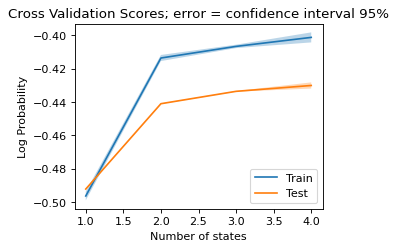

In [21]:
## plot train and test scores for each model and display confidence intervals
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(num_states, [np.mean(s) for s in stationary_train_scores], label="Train")
plt.plot(num_states, [np.mean(s) for s in stationary_test_scores], label="Test")
plt.fill_between(num_states, [s[0] for s in stationary_train_scores_ci], [s[1] for s in stationary_train_scores_ci], alpha=0.3)
plt.fill_between(num_states, [s[0] for s in stationary_test_scores_ci], [s[1] for s in stationary_test_scores_ci], alpha=0.3)
plt.legend(loc="lower right")
plt.xlabel("Number of states")
plt.ylabel("Log Probability")
plt.title("Cross Validation Scores; error = confidence interval 95%")
plt.show()


In [22]:
for ii in range(len(stationary_model_list)):
    log_likelihood = stationary_model_list[ii].log_likelihood(choices, inputs=inpts)
    print('Model with ' + str(num_states[ii]) + ' states has a train log likelihood of ' + str(log_likelihood))

Model with 1 states has a train log likelihood of -129068.9816398342
Model with 2 states has a train log likelihood of -114180.85050544246
Model with 3 states has a train log likelihood of -110885.58578415863
Model with 4 states has a train log likelihood of -109228.2069112714


In [23]:
##determine LL of held out test data
test_choices = test_data['Decision'].to_numpy()
test_choices = test_choices.reshape(-1, 1)
test_choices = test_choices.astype(int)

test_inpts = test_data_x.to_numpy()
stationary_test_ll_list = []

for ii in range(len(stationary_model_list)):
    stationary_test_ll_list.append(stationary_model_list[ii].log_likelihood(test_choices, inputs=test_inpts))
    print('Model with ' + str(num_states[ii]) + ' states has a test log likelihood of ' + str(stationary_test_ll_list[ii]))

Model with 1 states has a test log likelihood of -14618.168513744757
Model with 2 states has a test log likelihood of -12798.111426241961
Model with 3 states has a test log likelihood of -12417.940130556333
Model with 4 states has a test log likelihood of -12237.160088635675


In [24]:
##normalize log likelihood in test_glmhmm_list and test_ll_list
stationary_norm_ll_list = []
stationary_norm_test_ll_list = []
for ii in range(len(stationary_ll_list)):
    stationary_norm_ll_list.append([k / num_trials_per_train_sess for k in stationary_ll_list[ii] if k is not None])
    stationary_norm_test_ll_list.append((stationary_test_ll_list[ii]/num_trials_per_test_sess))

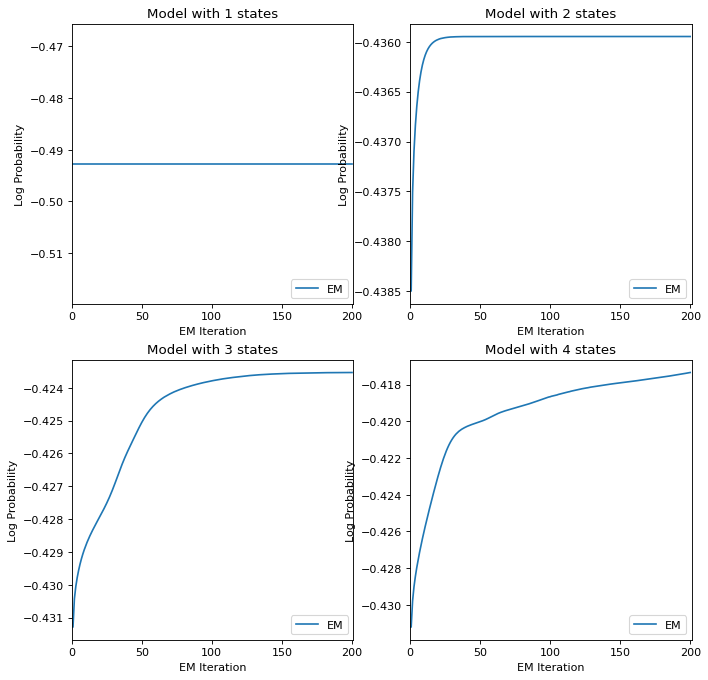

In [25]:
## Plot subplots of the log probabilities of the train and test models. Fit model final LL should be greater
# than or equal to true LL.
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
axs = axs.ravel()
for ii in range(len(stationary_ll_list)):
    axs[ii].plot(stationary_norm_ll_list[ii], label="EM")
    #axs[ii].plot([0, len(stationary_norm_ll_list[ii])], stationary_norm_test_ll_list[ii] * np.ones(2), ':k', label="Test")
    axs[ii].legend(loc="lower right")
    axs[ii].set_xlabel("EM Iteration")
    axs[ii].set_xlim(0, len(stationary_norm_ll_list[ii]))
    axs[ii].set_ylabel("Log Probability")
    axs[ii].set_title('Model with ' + str(num_states[ii]) + ' states')

In [26]:
##Convert to bits per state for train data
stationary_bits_per_state_train = []
for ii in range(len(stationary_model_list)):
    import math
    bits_per_sess = ((stationary_model_list[ii].log_likelihood(choices, inputs=inpts)-(np.log(0.5)*num_trials_per_train_sess))/(num_trials_per_train_sess*np.log(2)))
    stationary_bits_per_state_train.append(bits_per_sess)

In [27]:
##Convert to bits per state for test data
stationary_bits_per_state_test = []
for ii in range(len(stationary_model_list)):
    import math
    bits_per_sess = ((stationary_model_list[ii].log_likelihood(test_choices, inputs=test_inpts)-(np.log(0.5)*num_trials_per_test_sess))/(num_trials_per_test_sess*np.log(2)))
    stationary_bits_per_state_test.append(bits_per_sess)

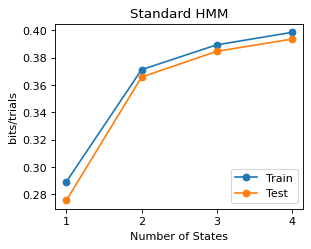

In [29]:
##Plot bits/state train vs test
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(num_states, stationary_bits_per_state_train, label="Train", marker='o')
plt.plot(num_states, stationary_bits_per_state_test, label="Test", marker='o')
plt.legend(loc="lower right")
plt.xlabel("Number of States")
plt.ylabel("bits/trials")
plt.xticks(num_states)
plt.title('Standard HMM')
plt.show()

In [30]:
##Calculate AIC  for train data normalized by number of trials
stationary_AIC_train = []
for ii in range(len(stationary_model_list)):
    AIC = (-2*(stationary_model_list[ii].log_likelihood(choices, inputs=inpts)/num_trials_per_train_sess))+(2*(num_states[ii]))
    stationary_AIC_train.append(AIC)

In [31]:
##Calculate AIC  for train data normalized by number of trials
stationary_AIC_test = []
for ii in range(len(stationary_model_list)):
    AIC = (-2*(stationary_model_list[ii].log_likelihood(test_choices, inputs=test_inpts)/num_trials_per_test_sess))+(2*(num_states[ii]))
    stationary_AIC_test.append(AIC)

([<matplotlib.axis.XTick at 0x25003790c10>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

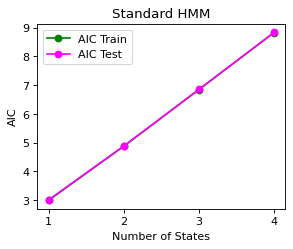

In [32]:
##Plot AIC for train and test data side by side
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.4)

plt.plot(num_states, stationary_AIC_train, label="AIC Train", marker='o', color='green')
plt.plot(num_states, stationary_AIC_test, label="AIC Test", marker='o', color='magenta')
plt.legend(loc="upper left")
plt.xlabel("Number of States")
plt.title('Standard HMM')
plt.ylabel("AIC")
plt.xticks(num_states)


In [33]:
# # Get expected states for each model:
expectations_list = []
for i in range(len(num_states)):
    expectations_list.append([stationary_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])])
    
## Get expected states for held out test data for each model:
stationary_test_expectations_list = []
for i in range(len(num_states)):
    stationary_test_expectations_list.append([stationary_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([test_choices], [test_inpts])])

In [34]:
# calculate predicitve accuracy for test data for each model
stationary_test_predictive_acc_list = []
for i in range(len(num_states)):
    model = stationary_model_list[i]
    expectations = stationary_test_expectations_list[i]
    glm_weights = -model.observations.params
    permutation = np.argsort(glm_weights[:, 0, 0])
    masks = [np.ones_like(data, dtype=bool) for data in [test_choices]]
    # Convert this now to one array:
    posterior_probs = np.concatenate(expectations, axis=0)
    posterior_probs = posterior_probs[:, permutation]
    prob_right = [
        np.exp(model.observations.calculate_logits(input=test_inpts))
        for data, input, train_mask in zip(test_choices, test_inpts, masks)
    ]
    prob_right = np.concatenate(prob_right, axis=0)
    # Now multiply posterior probs and prob_right:
    prob_right = prob_right[:, :, 1] ## taking logits running an exponential then arranging in a 3d array
    # Now multiply posterior probs and prob_right and sum over latent axis:
    final_prob_right = np.sum(np.multiply(posterior_probs, prob_right), axis=1)
    # Get the predicted label for each time step:
    predicted_label = np.around(final_prob_right, decimals=0).astype('int')
    # Examine at appropriate idx
    predictive_acc = np.sum(test_choices[:, 0] == predicted_label) / len(test_choices)
    print('Model with ' + str(num_states[i]) + ' state(s) has a test predictive accuracy of ' + str(predictive_acc))
    stationary_test_predictive_acc_list.append(predictive_acc)


Model with 1 state(s) has a test predictive accuracy of 0.774884935082778
Model with 2 state(s) has a test predictive accuracy of 0.39231984612214055
Model with 3 state(s) has a test predictive accuracy of 0.4833413478051796
Model with 4 state(s) has a test predictive accuracy of 0.871058597238442


Text(0.5, 1.0, 'Standard Model')

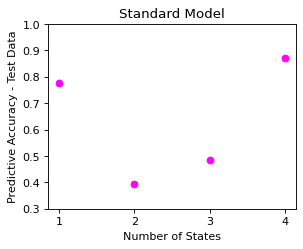

In [36]:
# Dot plot of predictive accuracy for each model
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(num_states, stationary_test_predictive_acc_list, marker='o', color='magenta')
plt.xlabel("Number of States")
plt.ylabel("Predictive Accuracy - Test Data")
plt.ylim(0.3, 1)
plt.xticks(num_states)
plt.title('Standard Model')

Text(0.5, 1.0, 'Standard HMM')

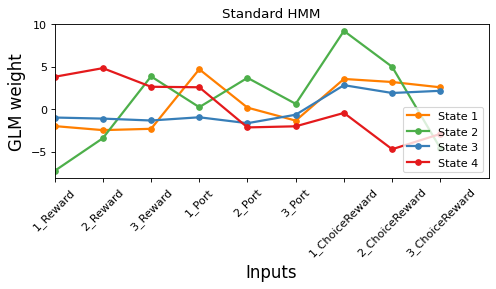

In [63]:
num_states_2plot = 4
model_to_plot = (num_states_2plot-1) #remember, 0 indexed

stationary_gen_weights = -stationary_model_list[model_to_plot].observations.params #select correct model whether in list, or just test_glmhmm
cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c']
# Plot the GLM weights for each input regressor against each state for the model with 2 states
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
for k in range(num_states_2plot):
    plt.plot(stationary_gen_weights[k,0,:], label="State " + str(k + 1), lw=2,
             color=cols[k], marker = 'o', markersize = 5)
plt.legend(loc="lower right")
plt.xticks(np.arange(len(x_cols)), x_cols, rotation=45, fontsize = 10)
plt.ylabel("GLM weight", fontsize = 15)
plt.xlabel("Inputs", fontsize = 15)
plt.xlim((0, len(x_cols)))
plt.title('Standard HMM')


In [38]:
#Loop through all models to get posterior probabilities for train data and state_occupancies
posterior_probs_list = []
state_occupancies_list = []
for i in range(len(num_states)):
    posterior_probs = [stationary_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])]
    posterior_probs_concat = np.concatenate(posterior_probs)
    state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
    _, state_occupancies = np.unique(state_max_posterior, return_counts=True)
    state_occupancies = state_occupancies/np.sum(state_occupancies)
    posterior_probs_list.append(posterior_probs)
    state_occupancies_list.append(state_occupancies)

#Loop through all models to get posterior probabilities for test data and state_occupancies
stationary_test_posterior_probs_list = []
stationary_test_state_occupancies_list = []
for i in range(len(num_states)):
    stationary_test_posterior_probs = [stationary_model_list[i].expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([test_choices], [test_inpts])]
    stationary_test_posterior_probs_concat = np.concatenate(stationary_test_posterior_probs)
    stationary_test_state_max_posterior = np.argmax(stationary_test_posterior_probs_concat, axis = 1)
    _, stationary_test_state_occupancies = np.unique(stationary_test_state_max_posterior, return_counts=True)
    stationary_test_state_occupancies = stationary_test_state_occupancies/np.sum(stationary_test_state_occupancies)
    stationary_test_posterior_probs_list.append(stationary_test_posterior_probs)
    stationary_test_state_occupancies_list.append(stationary_test_state_occupancies)

Text(0.5, 1.0, 'Standard HMM')

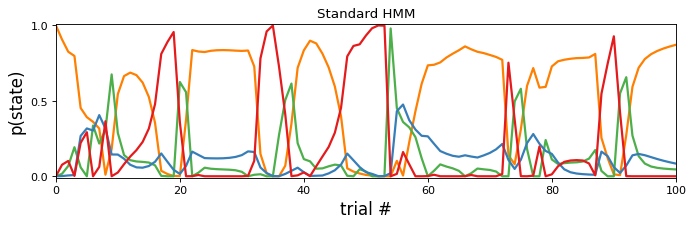

In [62]:
trials_to_plot = (0, 100) # number of trials to plot
num_states_2plot = 4
model_to_plot = (num_states_2plot-1) #remember, 0 indexed
sess_id = 0 #session id; can choose any index between 0 and num_sess-1

cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c']
fig = plt.figure(figsize=(10, 2.5), dpi=80, facecolor='w', edgecolor='k')

for k in range(num_states_2plot):
    posterior_probs = posterior_probs_list[model_to_plot]
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlim(trials_to_plot) 
plt.xlabel("trial #", fontsize = 15)

plt.ylabel("p(state)", fontsize = 15)
plt.title('Standard HMM')

Text(0.5, 1.0, 'Standard HMM')

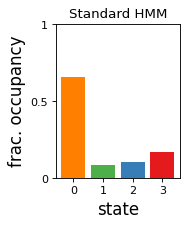

In [58]:
num_states_2plot = 4
model_to_plot = (num_states_2plot-1) #remember, 0 indexed

fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(stationary_test_state_occupancies_list[model_to_plot]):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks(range(num_states_2plot), range(num_states_2plot), fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)
plt.title('Standard HMM')

Text(0.5, 1.0, 'Generative transition matrix - Standard')

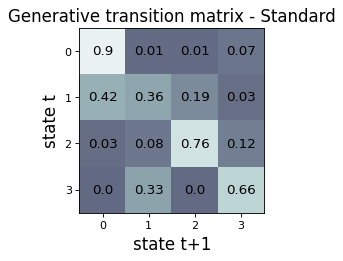

In [59]:
#plot transition matrix
num_states_2plot = 4
model_to_plot = (num_states_2plot-1) #remember, 0 indexed

gen_weights = stationary_model_list[model_to_plot].observations.params #select correct model whether in list, or just test_glmhmm
gen_trans_mat = stationary_model_list[model_to_plot].transitions.params #select correct model whether in list, or just test_glmhmm


# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states_2plot - 0.5)
plt.xticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.yticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.ylim(num_states_2plot - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix - Standard", fontsize = 15)

## 3. We've been looping through a list of states, but we can also just select a single state and run the model on it

### 3a. Fit GLM-HMM and perform recovery analysis -- this should come after the model selection section above

In [ ]:
# Data inputs 
choices = train_data['Decision'].to_numpy()
choices = choices.reshape(-1, 1)
choices = choices.astype(int)

inpts = train_data_x.to_numpy()

# Model Inputs
num_states = 3 # number of discrete states
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output
input_dim = inpts.shape[1]

In [ ]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard") # transitions usually standard


In [ ]:
## perform cross-validation
from ssm import model_selection
test_scores, train_scores = ssm.model_selection.cross_val_scores(new_glmhmm, choices, inpts, heldout_frac=0.1, n_repeats=5, verbose=True)

In [ ]:
N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(choices, inputs=inpts, method='em', num_iters=N_iters, tolerance=10**-4) #method="em",
print("EM converged: ", fit_ll)

In [ ]:
#fit to test data
test_choices = test_data['Decision'].to_numpy()
test_choices = test_choices.reshape(-1, 1)
test_choices = test_choices.astype(int)

test_inpts = test_data_x.to_numpy()

test_ll = new_glmhmm.log_likelihood(test_choices, inputs=test_inpts)
print("Test LL: ", test_ll)

In [ ]:
#normalize the log likelihood
norm_ll = [s / num_trials_per_train_sess for s in fit_ll if s is not None]
norm_test = test_ll / num_trials_per_test_sess

In [ ]:
# Plot the log probabilities of the train and test models. Fit model final LL should be greater 
# than or equal to true LL.

fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(norm_ll, label="EM")
plt.plot([0, len(norm_ll)], norm_test * np.ones(2), ':k', label="Test")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### 3b. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [ ]:
T = inpts.shape[0] # number of trials
K = 2 # number of latent states
C = 2 # number of observation classes or # C represents the binary choice the animal must make
D = inpts.shape[1] # number of GLM inputs (regressors)

# # Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([choices], [inpts])]

In [ ]:
trials_to_plot = (0, 300) # number of trials to plot

cols = ['#ff7f00', '#4daf4a', '#377eb8']
fig = plt.figure(figsize=(10, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlim(trials_to_plot) 
plt.xlabel("trial #", fontsize = 15)

plt.ylabel("p(state)", fontsize = 15)

In [ ]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

In [ ]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

In [ ]:
model_gen_weights = new_glmhmm.observations.params

#Plot the weights for each input regressor against each state
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
for k in range(num_states):
    plt.plot(model_gen_weights[k,0,:], label="State " + str(k + 1), lw=2,
             color=cols[k], marker = 'o', markersize = 5)
plt.legend(loc="lower right")
plt.xticks(np.arange(len(x_cols)), x_cols, rotation=45, fontsize = 10)
plt.ylabel("GLM weight", fontsize = 15)
plt.xlabel("Inputs", fontsize = 15)
plt.xlim((0, len(x_cols)))


In [ ]:
num_states_2plot = num_states
gen_weights = new_glmhmm.observations.params #select correct model whether in list, or just test_glmhmm
gen_trans_mat = new_glmhmm.transitions.params #select correct model whether in list, or just test_glmhmm


# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states_2plot - 0.5)
plt.xticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.yticks(range(0, num_states_2plot), range(num_states_2plot), fontsize=10)
plt.ylim(num_states_2plot - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

In [ ]:
train_data.loc[:, 'State_Occupancy'] = state_max_posterior # State_Max_Posterior contains the state for each given trial 

#save new csv
#filtered_data.to_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FullMerged_2nBack_100423.csv', index=True)